**Question 2**

In your local machine’s Spark setup, develop a PySpark program using Spark DataFrame APIs to perform the following tasks. 

Show your full PySpark program and provide screenshots for all key steps where applicable.

Data sources used in this question is: 

airbnb_data.csv. 

Note that this data file can be downloaded from ICT337 Canvas webpage.

In [57]:
#Import libraries
from pyspark.sql import SparkSession

from pyspark.sql import functions as f

from pyspark.sql.functions import *

from functools import reduce

from pyspark.sql.functions import avg, desc, round

from pyspark.sql.types import IntegerType, DoubleType, DateType, NumericType

from pyspark.sql.functions import to_date

from pyspark.sql.functions import lower, trim, when

from pyspark.sql.functions import sum, col

from pyspark.sql.functions import sum as spark_sum, col

from pyspark.sql.functions import col, avg, format_number

import matplotlib.pyplot as plt

import seaborn as sns

import pandas as pd

import numpy as np


""" Set the SPARK_LOCAL_IP environment variable: Before running your script, set this environment variable: """
import os
os.environ['SPARK_LOCAL_IP'] = 'localhost'

# Start spark session

""" Set the spark.driver.bindAddress: Add the following configuration to your SparkSession builder:

Use a specific port: If the issue persists, try specifying a port explicitly: """
spark = SparkSession \
    .builder \
    .appName("ICT337 ECA July 2024 Semester Question 2") \
    .config("spark.driver.bindAddress", "localhost") \
    .config("spark.driver.port", "4043") \
    .config("spark.some.config.option", "some-value") \
    .getOrCreate()

**Question 2(a) (6 marks)**

Perform the following tasks and show the results in each step:

+ Read the “airbnb_data.csv” and store the content using Spark DataFrames. 
  
  Show the content, schema and DataFrame dimension.

+ Find any missing data from the DataFrame. 
  
  If so, drop the corresponding rows. 
  
  Show the details of before and after the missing value clean up.

+ Find the basic statistics associated with each data column.

In [58]:
""" Question 2(a) (6 marks) """
print("\nQuestion 2(a) (6 marks)\n")

# Read csv file and store into dataframe
airbnb_data_PySpark_DF = spark\
    .read\
        .option("inferSchema", "true")\
            .option("header", "true")\
                .csv("/Users/shawnyang/Downloads/ICT337 ECA July 2024 Semester/ECA Datasets/airbnb_data.csv")

""" 
Sample airbnb_data.csv data: 

id,name,host_id,host_name,neighbourhood_group,neighbourhood,latitude,longitude,room_type,price,minimum_nights,number_of_reviews,last_review,reviews_per_month,calculated_host_listings_count,availability_365
"""

# Show the type of the object to check if its a dataframe
print(f"Show the type of the Airbnb Data DataFrame:\n{type(airbnb_data_PySpark_DF)}\n")

print("Show the content of airbnb data:\n")

airbnb_data_PySpark_DF.show(20)


""" To change the data types of the columns in your airbnb_data_PySpark_DF based on their content, 
you can use the following PySpark code: 

This code will change the data types as follows:

Integer columns: id, host_id, minimum_nights, number_of_reviews, calculated_host_listings_count

Double (decimal) columns: latitude, longitude, price, reviews_per_month

Date column: last_review

The other columns (name, host_name, neighbourhood_group, neighbourhood, room_type) will remain as strings. """
airbnb_data_PySpark_DF = airbnb_data_PySpark_DF\
    .withColumn("id", airbnb_data_PySpark_DF["id"].cast(IntegerType())) \
    .withColumn("host_id", airbnb_data_PySpark_DF["host_id"].cast(IntegerType())) \
    .withColumn("latitude", airbnb_data_PySpark_DF["latitude"].cast(DoubleType())) \
    .withColumn("longitude", airbnb_data_PySpark_DF["longitude"].cast(DoubleType())) \
    .withColumn("price", airbnb_data_PySpark_DF["price"].cast(DoubleType())) \
    .withColumn("minimum_nights", airbnb_data_PySpark_DF["minimum_nights"].cast(IntegerType())) \
    .withColumn("number_of_reviews", airbnb_data_PySpark_DF["number_of_reviews"].cast(IntegerType())) \
    .withColumn("last_review", to_date(airbnb_data_PySpark_DF["last_review"])) \
    .withColumn("reviews_per_month", airbnb_data_PySpark_DF["reviews_per_month"].cast(DoubleType())) \
    .withColumn("calculated_host_listings_count", airbnb_data_PySpark_DF["calculated_host_listings_count"].cast(IntegerType()))


print("Display the schema of the Airbnb Data DataFrame:\n")

""" This shows the structure of the DataFrame, including column names and their data types. """
airbnb_data_PySpark_DF.printSchema()

# Show the dimensions (number of rows and columns) of the DataFrame
""" .count() and len(airbnb_data_DataFrame.columns): These get the number of rows and columns in the DataFrame. """
print(f"Airbnb Data DataFrame Dimensions (number of rows and columns):\n({airbnb_data_PySpark_DF.count()}, {len(airbnb_data_PySpark_DF.columns)})\n")


# Find missing data
print("Check for missing data in each column and display the count:\n")

# Initialize an empty list to store column expressions
airbnb_data_column_Expressions = []

# Iterate through each column in the DataFrame
for airbnb_data_column in airbnb_data_PySpark_DF.columns:
    # Create an expression to count null values for the current column
    null_count_for_column_Expression = count(when(col(airbnb_data_column).isNull(), airbnb_data_column)).alias(airbnb_data_column)
    # Add the expression to the list
    airbnb_data_column_Expressions.append(null_count_for_column_Expression)

# Use select() with the list of expressions to create the missing_data DataFrame
missing_data_PySpark_DF = airbnb_data_PySpark_DF.select(airbnb_data_column_Expressions)

missing_data_PySpark_DF.show()


""" This code selects only the "room_type" column from the DataFrame.  """
distinct_room_types_PySpark_DF = airbnb_data_PySpark_DF.select("room_type").distinct().collect()

""" This code will show you all the distinct values in the room_type column and count them. """
print(f"\nTotal number of distinct room types: {len(distinct_room_types_PySpark_DF)}\n")


""" To clean up the room_type column and ensure you only have the three expected values, 
you can use a combination of string manipulation and filtering. """
airbnb_data_with_distinct_room_types_PySpark_DF = airbnb_data_PySpark_DF.withColumn(
    "room_type",
    when(
        lower(trim("room_type")).isin(["private room", "shared room", "entire home/apt"]), 

        lower(trim("room_type"))
    )\
        .otherwise("unknown")
)

""" This code selects only the "room_type" column from the DataFrame.  """
distinct_room_types = airbnb_data_with_distinct_room_types_PySpark_DF.select("room_type").distinct().collect()

print("Distinct room types after cleaning:")

""" It then iterates through each row in the distinct_room_types list 

For each row, it prints the value of the "room_type" column """
for row in distinct_room_types:
    print(row["room_type"])

""" After printing all distinct room types, it prints the total count of distinct room types using len(distinct_room_types) """
print(f"\nTotal number of distinct room types after cleaning: {len(distinct_room_types)}\n")


# Count total rows before dropping missing values
total_rows_before_dropping_missing_values_PySpark_DF = airbnb_data_with_distinct_room_types_PySpark_DF.count()

print(f"Show the number of rows before dropping missing values: {total_rows_before_dropping_missing_values_PySpark_DF}\n")


# Drop rows with missing values
""" Create a new DataFrame with missing values removed. """
airbnb_data_cleaned_PySpark_DF = airbnb_data_with_distinct_room_types_PySpark_DF.dropna()

# Count total rows after dropping missing values
total_rows_after_dropping_missing_values_PySpark_DF = airbnb_data_cleaned_PySpark_DF.count()

print(f"Show the number of rows after dropping missing values: {total_rows_after_dropping_missing_values_PySpark_DF}\n")


# Calculate the number of rows dropped
""" Calculate and display the number of rows that were dropped. """
total_rows_dropped_PySpark_DF = total_rows_before_dropping_missing_values_PySpark_DF - total_rows_after_dropping_missing_values_PySpark_DF

print(f"Number of rows that were dropped: {total_rows_dropped_PySpark_DF}\n")


# Show a few rows of the cleaned DataFrame
print("Show a sample of the cleaned DataFrame:\n")

airbnb_data_cleaned_PySpark_DF.show(20)


""" Calculate basic statistics for all columns

This code will generate a summary of basic statistics for all columns in your DataFrame, including:"""
basic_stats_PySpark_DF = airbnb_data_cleaned_PySpark_DF.describe()

# Show the results
print("Basic statistics for each column:\n")

basic_stats_PySpark_DF.show()




Question 2(a) (6 marks)

Show the type of the Airbnb Data DataFrame:
<class 'pyspark.sql.dataframe.DataFrame'>

Show the content of airbnb data:

+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|       host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+----------------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|            John|           Brooklyn|        Kensington|40.64749|-73.97237|   Private 

Question 2(b) (6 marks)

Find the Top Ten (10) Airbnb’s neighbourhood_group from the highest to lowest average price. 

Show the DataFrame content and visualize the result in a plot accordingly. 

Repeat the computation for the neighbourhood category.

Note that for the ease of using Matplotlib/Seaborn plotting, you may use “toPandas()” to convert a Spark DataFrame into Pandas DataFrame.


Question 2(b) (6 marks)

Show the top 10 Airbnb's neighbourhood_group sorted from highest to lowest average price:

+-------------------+-------------+
|neighbourhood_group|average_price|
+-------------------+-------------+
|          Manhattan|       180.19|
|           Brooklyn|       121.49|
|             Queens|        95.83|
|      Staten Island|        90.42|
|              Bronx|        79.75|
+-------------------+-------------+

Display the Pandas DataFrame:

  neighbourhood_group  average_price
0           Manhattan         180.19
1            Brooklyn         121.49
2              Queens          95.83
3       Staten Island          90.42
4               Bronx          79.75


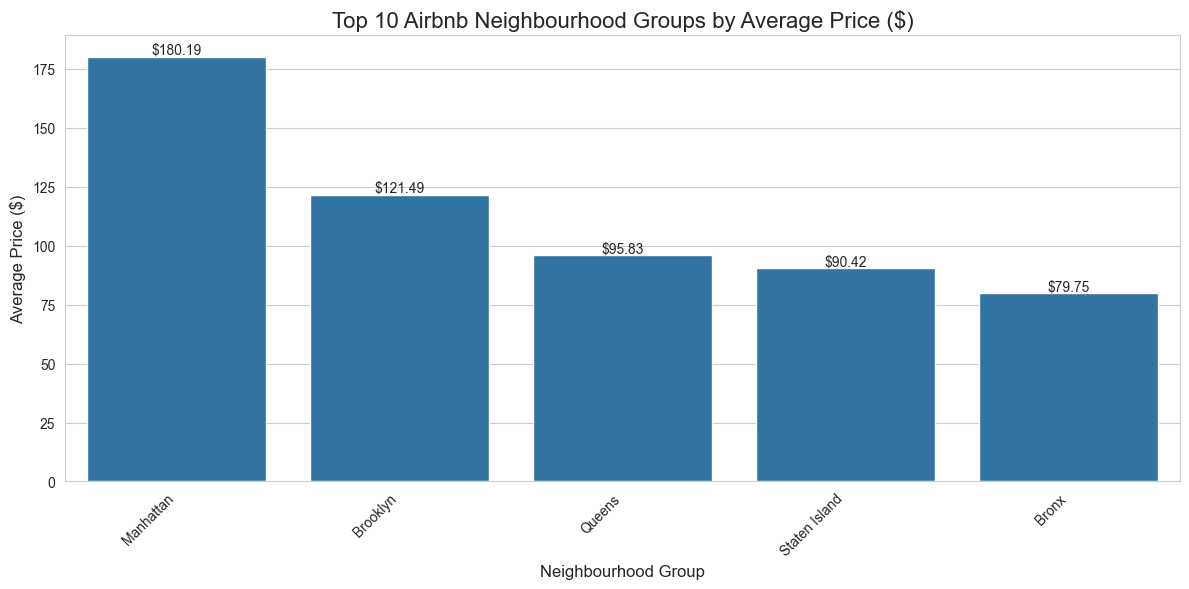

Show the top 10 Airbnb's neighbourhood sorted from highest to lowest average price:

+-----------------+-------------+
|    neighbourhood|average_price|
+-----------------+-------------+
|         Sea Gate|       601.67|
|          Tribeca|        460.3|
|             NoHo|       301.25|
|Flatiron District|       291.48|
|             SoHo|        281.5|
|         Neponsit|       274.67|
|          Midtown|       267.64|
|     West Village|       250.45|
|      Willowbrook|        249.0|
|Greenwich Village|       238.85|
+-----------------+-------------+

Display the Pandas DataFrame:

       neighbourhood  average_price
0           Sea Gate         601.67
1            Tribeca         460.30
2               NoHo         301.25
3  Flatiron District         291.48
4               SoHo         281.50
5           Neponsit         274.67
6            Midtown         267.64
7       West Village         250.45
8        Willowbrook         249.00
9  Greenwich Village         238.85


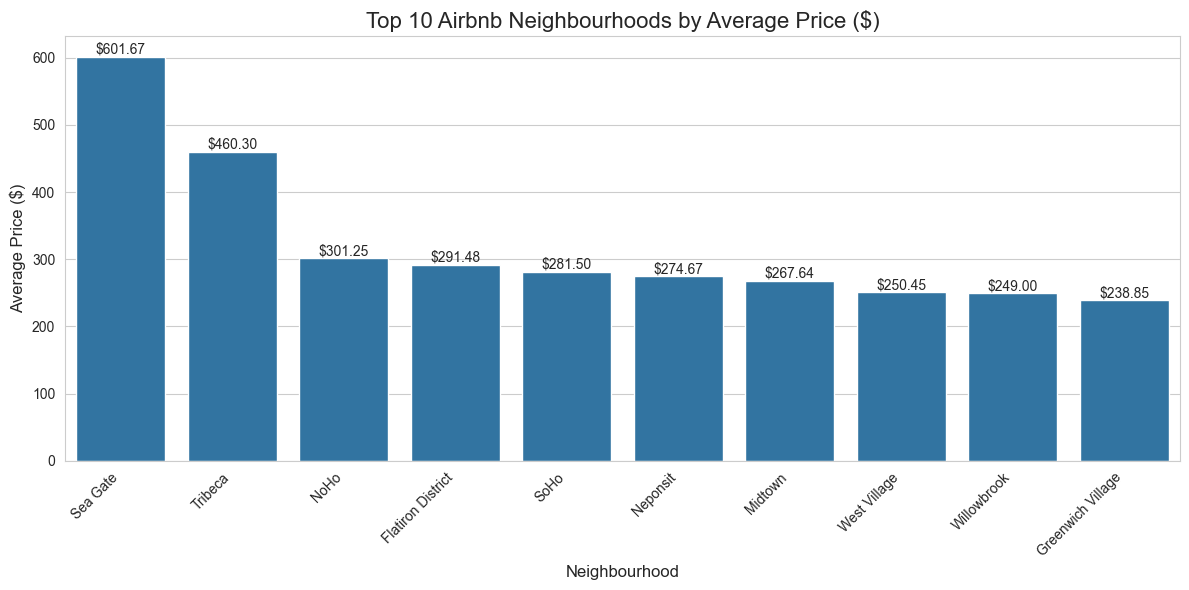

In [59]:
""" Question 2(b) (6 marks) """
print("\nQuestion 2(b) (6 marks)\n")


""" Group by neighbourhood_group and calculate average price

Order the results by average price in descending order

Limit the output to the top 10 results  """
neighbourhood_group_average_price_PySpark_DF = airbnb_data_cleaned_PySpark_DF.groupBy("neighbourhood_group") \
    .agg(round(avg("price"), 2).alias("average_price")) \
    .orderBy(desc("average_price")) \
    .limit(10)

print("Show the top 10 Airbnb's neighbourhood_group sorted from highest to lowest average price:\n")

# Show the results
neighbourhood_group_average_price_PySpark_DF.show()


""" Convert the Spark DataFrame to a Pandas DataFrame using toPandas(). """
neighbourhood_group_average_price_Pandas_DF = neighbourhood_group_average_price_PySpark_DF.toPandas()

# Display the Pandas DataFrame
print(f"Display the Pandas DataFrame:\n\n{neighbourhood_group_average_price_Pandas_DF}")


""" Set up the plot size. """
plt.figure(figsize=(12, 6))

""" Set up the plot style. """
sns.set_style("whitegrid")

""" Create a bar plot using seaborn's barplot function. """
ax = sns.barplot(x='neighbourhood_group', y='average_price', data=neighbourhood_group_average_price_Pandas_DF)

""" Customize the plot with a title. """
plt.title('Top 10 Airbnb Neighbourhood Groups by Average Price ($)', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Neighbourhood Group', fontsize=12)

plt.ylabel('Average Price ($)', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=45, ha='right')

""" Add value labels on top of each bar for precise price information. """
for i, v in enumerate(neighbourhood_group_average_price_Pandas_DF['average_price']):
    ax.text(i, v, f'${v:.2f}', ha='center', va='bottom')

""" Adjust the layout of the plot """
plt.tight_layout()

""" Display the plot. """
plt.show()


""" Group the data by neighbourhood and Calculate the average price for each neighbourhood

Order the results by average price in descending order

Limit the output to the top 10 results """
neighbourhood_average_price_PySpark_DF = airbnb_data_cleaned_PySpark_DF.groupBy("neighbourhood") \
    .agg(round(avg("price"), 2).alias("average_price")) \
    .orderBy(desc("average_price")) \
    .limit(10)

print("Show the top 10 Airbnb's neighbourhood sorted from highest to lowest average price:\n")

# Show the results
neighbourhood_average_price_PySpark_DF.show()


""" Convert the Spark DataFrame to a Pandas DataFrame using toPandas(). """
neighbourhood_average_price_Pandas_DF = neighbourhood_average_price_PySpark_DF.toPandas()

# Display the Pandas DataFrame
print(f"Display the Pandas DataFrame:\n\n{neighbourhood_average_price_Pandas_DF}")


""" Set up the plot size. """
plt.figure(figsize=(12, 6))

""" Set up the plot style. """
sns.set_style("whitegrid")

""" Create a bar plot using seaborn's barplot function. """
ax = sns.barplot(x='neighbourhood', y='average_price', data=neighbourhood_average_price_Pandas_DF.head(10))

""" Customize the plot with a title. """
plt.title('Top 10 Airbnb Neighbourhoods by Average Price ($)', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Neighbourhood', fontsize=12)

plt.ylabel('Average Price ($)', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=45, ha='right')

""" Add value labels on top of each bar for precise price information. """
for i, v in enumerate(neighbourhood_average_price_Pandas_DF['average_price'][:10]):
    ax.text(i, v, f'${v:.2f}', ha='center', va='bottom')

""" Adjust the layout of the plot """
plt.tight_layout()

""" Display the plot. """
plt.show()




**Top 10 Airbnb Neighbourhood Groups by Average Price Bar Graph Insights:**

1st Insight:

The 1st insight is that the Manhatan neighourhood group is the most expensive neighbourhood group because it has the highest average price of $180.19.

This insight also may mean that the Manhatan neighourhood group is the more luxurious option that caters to wealthier customers or business customers.

2nd Insight:

The 2nd insight is that the Bronx neighourhood group is the least expensive neighbourhood group because it has the lowest average price of $79.75.

This insight also may mean that the Bronx neighourhood group is the most affordable option that caters to budget-conscious customers or customers who cannot afford the more expensive alternatives.

**Top 10 Airbnb Neighbourhoods by Average Price Bar Graph Insights:**

1st Insight:

The 1st insight is that the most expensive neighbourhood is Sea Gate which has an average price of $601.67.

The 2nd most expensive neighbourhood is Tribeca which has an average price of $460.30

The least expensive neighbourhood is Greenwhich Village which has an average price of $238.85.

This insight means that there is a large variation in average prices across the various neighbourhoods.

2nd Insight:

The 2nd insight is the neighbourhoods like NoHo, Flatiron District, SoHo, Neponsit, Midtown, West Village, Willowbrook and Greenwich Village have average prices ranging from $301.25 to $238.85 which suggest a small average price variation between them.

This insight also means that there are more afforadble neighbourhood options than expensive neighbourhood options.

**Question 2(c) (6 marks)**

Perform the following tasks and show the results in each step:

+ Append a new column of “popularity_index” to the DataFrame. 
  
  The popularity index is defined as the percentage of the total number of reviews of a given host over the sum of reviews across all hosts. 
  
  Show the Top Ten (10) most popular host (i.e., [host_id, popularity_index]).

+ Find the Top Ten (10) most popular neighbourhood based on the host’s popularity index. 
  
  Show the content and visualize the result in a plot.


Question 2(c) (6 marks)

Show a sample of the cleaned DataFrame:

+----+--------------------+-------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|  id|                name|host_id|  host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|
+----+--------------------+-------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+
|2539|Clean & quiet apt...|   2787|       John|           Brooklyn|        Kensington|40.64749|-73.97237|   private room|149.0|             1|                9| 2018-10-19|             0.21|                          

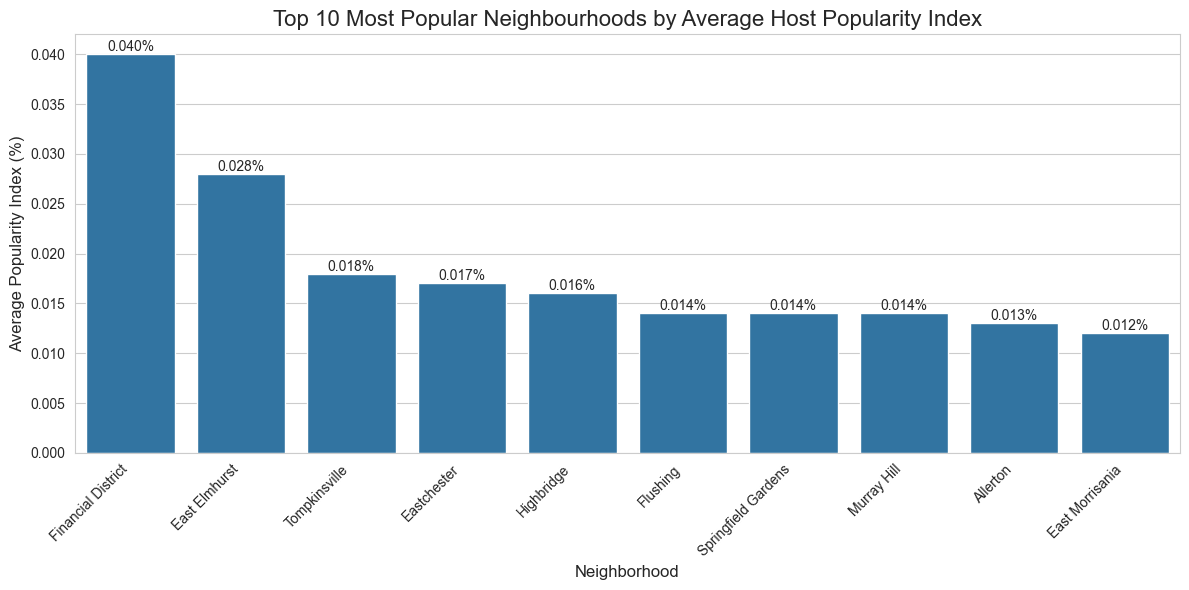

In [60]:
""" Question 2(c) (6 marks) """
print("\nQuestion 2(c) (6 marks)\n")


# Show a few rows of the cleaned DataFrame
print("Show a sample of the cleaned DataFrame:\n")

airbnb_data_cleaned_PySpark_DF.show(10)


""" Creates a new DataFrame with unique host_ids and their total number of reviews. """
airbnb_data_cleaned_unique_hosts_total_reviews_PySpark_DF = airbnb_data_cleaned_PySpark_DF\
    .groupBy("host_id") \
        .agg(spark_sum("number_of_reviews")\
             .alias("total_reviews_across_each_hosts"))

print("Updated DataFrame with unique hosts and their total reviews:\n")

# Show the results
airbnb_data_cleaned_unique_hosts_total_reviews_PySpark_DF.show(10)


""" Shows the top 10 unique hosts by total reviews  """
airbnb_data_cleaned_unique_hosts_total_reviews_PySpark_DF = airbnb_data_cleaned_unique_hosts_total_reviews_PySpark_DF.orderBy(
    col("total_reviews_across_each_hosts").desc()
)

# Show the updated DataFrame
print("Updated DataFrame with the top 10 unique hosts by total reviews:\n")

airbnb_data_cleaned_unique_hosts_total_reviews_PySpark_DF.show(10)


""" Calculates the new total number of reviews across all unique hosts """
total_Num_Of_Reviews_Across_All_Hosts = airbnb_data_cleaned_unique_hosts_total_reviews_PySpark_DF\
    .agg(spark_sum("total_reviews_across_each_hosts"))\
        .collect()[0][0]

print(f"New total number of reviews across all unique hosts: {total_Num_Of_Reviews_Across_All_Hosts}\n")


""" Calculate the popularity index for each host by adding a new column "popularity_index" to the DataFrame. 

Which is calculated as (total_reviews_across_each_hosts / new_total_reviews) * 100.  """
airbnb_data_with_popularity_index_PySpark_DF = airbnb_data_cleaned_unique_hosts_total_reviews_PySpark_DF.withColumn(
    "popularity_index_(%)",
    (col("total_reviews_across_each_hosts") / total_Num_Of_Reviews_Across_All_Hosts) * 100
)


print("Show each unique host, their total reviews and popularity index (%):\n")

""" Show the 1st 10 rows of the relevant columns to verify the new column has been added correctly. """
airbnb_data_with_popularity_index_PySpark_DF.show(10)


# Join the DataFrames

""" Joins the original DataFrame with the popularity index DataFrame on the "host_id" column."""
combined_PySpark_DF = airbnb_data_cleaned_PySpark_DF.join(airbnb_data_with_popularity_index_PySpark_DF, "host_id")

print("Show the combined DataFrame:\n")

combined_PySpark_DF.show(10)


""" This will display the hosts with the highest popularity index first,
giving you a quick view of the most popular hosts based on their share of total reviews. """
host_by_popularity_PySpark_DF = airbnb_data_with_popularity_index_PySpark_DF.select(
        "host_id", 
        format_number("popularity_index_(%)", 3)\
            .alias("popularity_index_(%)")
    ) \
    .orderBy(col("popularity_index_(%)").desc())

print("Top Ten (10) most popular host with the structure (i.e., [host_id, popularity_index]):\n")

# Show the results
host_by_popularity_PySpark_DF.show(10, truncate=False)


""" Creates a new DataFrame by selecting two specific columns from the combined_df DataFrame: 

    "neighbourhood": This column contains the names of different neighborhoods.

    "popularity_index_(%)": This column contains the popularity index for each neighborhood. """
neighborhood_by_popularity_PySpark_DF = combined_PySpark_DF.select("neighbourhood", "popularity_index_(%)")

print("Show the most popular neighbourhood by popularity DataFrame:\n")

neighborhood_by_popularity_PySpark_DF.show(10, truncate=False)


print("Show the neighbourhoods by average popularity DataFrame:\n")

""" Group the data by neighborhood and calculate the average popularity index for each neighborhood. """
neighborhood_by_average_popularity_PySpark_DF = neighborhood_by_popularity_PySpark_DF.groupBy("neighbourhood") \
    .agg(avg("popularity_index_(%)").alias("avg_popularity_index_(%)"))

neighborhood_by_average_popularity_PySpark_DF.show(10, truncate=False)


""" Sort the neighborhoods by their average popularity index in descending order and select the top 10 rows. """
sorted_neighborhood_by_average_popularity_PySpark_DF = neighborhood_by_average_popularity_PySpark_DF \
    .withColumn("avg_popularity_index_(%)", round(col("avg_popularity_index_(%)"), 3)) \
    .orderBy(col("avg_popularity_index_(%)").desc()) \
    .limit(10)

# Show the results
print("Top 10 Most Popular Neighborhoods based on Host's Popularity Index:")

sorted_neighborhood_by_average_popularity_PySpark_DF.show(10, truncate=False)


""" Converts the Spark DataFrame to a Pandas DataFrame for easier plotting """
sorted_neighborhood_by_average_popularity_Pandas_DF = sorted_neighborhood_by_average_popularity_PySpark_DF.toPandas()

# Display the Pandas DataFrame
print(f"Display the Pandas DataFrame:\n\n{sorted_neighborhood_by_average_popularity_Pandas_DF}")


# Set up the plot size
plt.figure(figsize=(12, 6))

# Set up the plot style
sns.set_style("whitegrid")

# Create a bar plot
ax = sns.barplot(x='neighbourhood', y='avg_popularity_index_(%)', data=sorted_neighborhood_by_average_popularity_Pandas_DF)

""" Customize the plot with a title. """
plt.title('Top 10 Most Popular Neighbourhoods by Average Host Popularity Index', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Neighborhood', fontsize=12)

plt.ylabel('Average Popularity Index (%)', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=45, ha='right')

""" Adds value labels on top of each bar for precise percentage information. """
for i, v in enumerate(sorted_neighborhood_by_average_popularity_Pandas_DF['avg_popularity_index_(%)']):
    ax.text(i, v, f'{v:.3f}%', ha='center', va='bottom')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()



**Top 10 Most Popular Neighborhoods by Average Host Popularity Index Bar Graph Insights:**

1st Insight:

The 1st insight is that the Financial District is the most popular neighbourhood with the highest average host popularity index of about 0.040% while East Morrisania is the least popular neighbourhood with the lowest average host popularity index of about 0.012%.

2nd Insight:

The 2nd insight is that the popularity of the neighbourhoods began to decrease gradually from Tompkinsville to East Morrisania with the average host popularity index ranging from about 0.018% to 0.012%. 

**Question 2(d) (6 marks)**

Perform the following tasks and show the results in each step:

+ Find the available room type from the input data.

+ Find the average price for a given neighbourhood and room type. 
  
  Organize your DataFrame in terms of these columns: [neighbourhood, room type 1, …, room type N].
  
  Sort the output by ascending alphabetical order of neighbourhood name.

+ Visualize the average price for the above Top Twenty (20) neighbourhood by different room types. 
  
  Note that you may use a side-by-side bar chart.


Question 2(d) (6 marks)

Show the combined DataFrame:

+-------+----+--------------------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------------------------+--------------------+
|host_id|  id|                name|  host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|total_reviews_across_each_hosts|popularity_index_(%)|
+-------+----+--------------------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------------------------+--------------------+
|   2787|2539|Clean & quiet apt...|       John|           Brooklyn| 

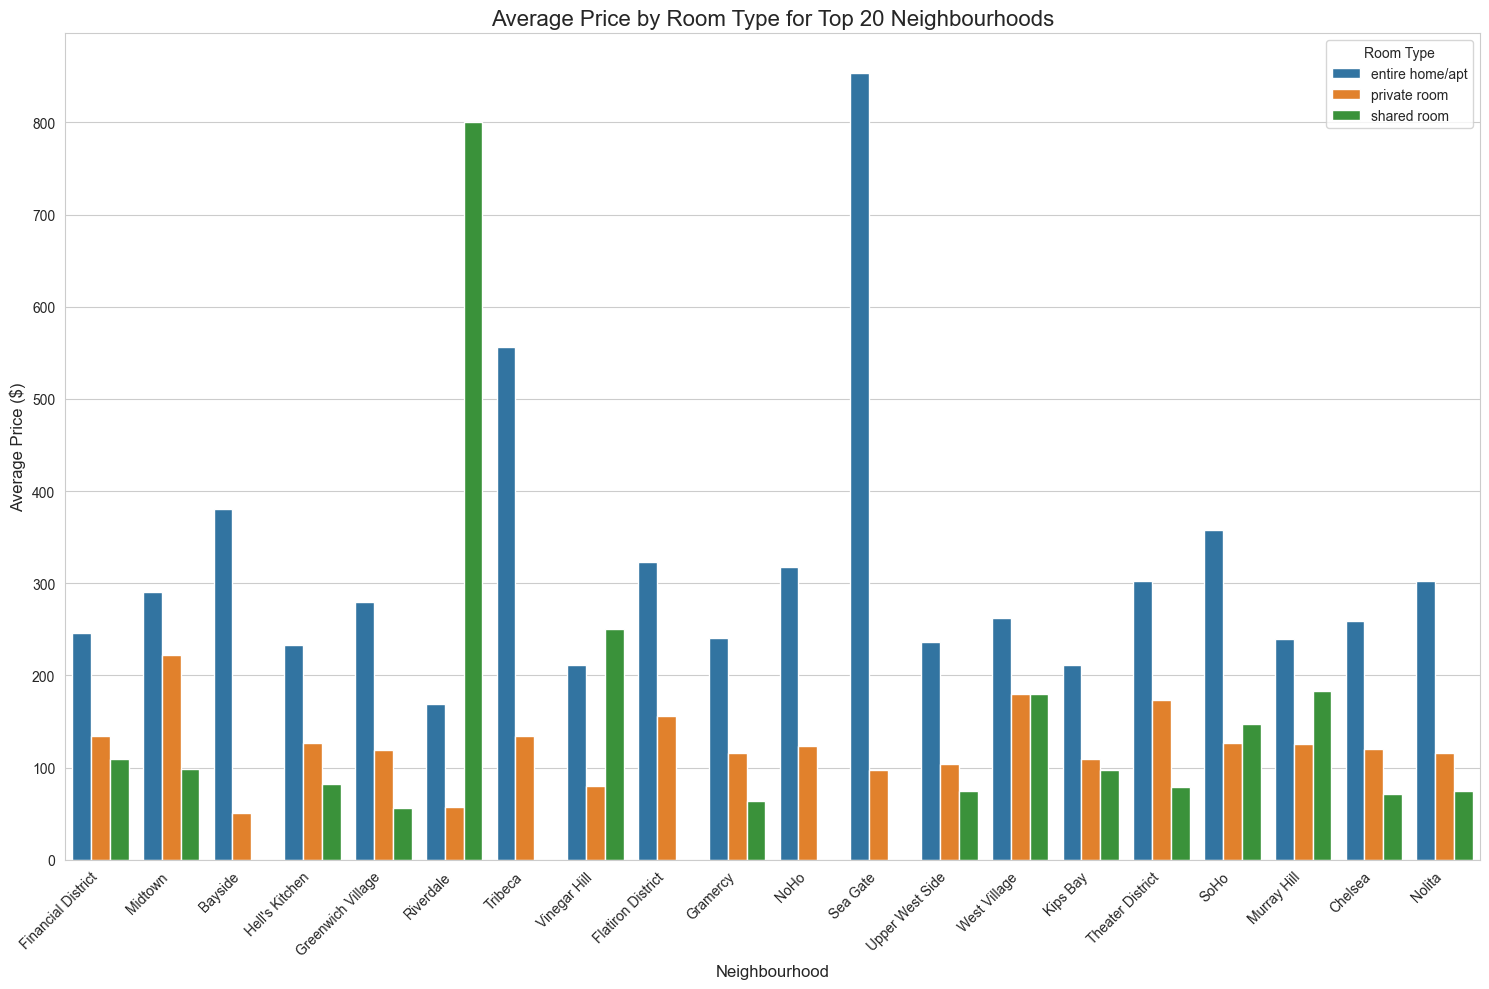

In [61]:
""" Question 2(d) (6 marks) """
print("\nQuestion 2(d) (6 marks)\n")

print("Show the combined DataFrame:\n")

combined_PySpark_DF.show(10)


""" Select the "room_type" column from the combined DataFrame. 

Use the distinct() function to get unique values. """
distinct_room_types_PySpark_DF = combined_PySpark_DF\
    .select("room_type")\
        .distinct()

# Show the results
print("Available room types:\n")

distinct_room_types_PySpark_DF.show()


""" Get a list of distinct room types from the previously created DataFrame. """

""" It creates an empty list room_types  """
room_types = []

""" Then iterates through each row in the DataFrame, 

appending the 'room_type' value from each row to the list.  """
for room_type_row in distinct_room_types_PySpark_DF.collect():
    room_types.append(room_type_row['room_type'])

print(f"Distinct room types: {room_types}\n")


""" Create a new DataFrame that calculates the average price for each combination of neighbourhood and room type. """
average_price_by_neighbourhood_room_type_PySpark_DF = combined_PySpark_DF\
    .groupBy("neighbourhood", "room_type")\
    .agg(
        round(avg("price"), 2).alias("avg_price")
    )

print("DataFrame with average price for each neighbourhood and room type:\n")

average_price_by_neighbourhood_room_type_PySpark_DF.show(10)


""" Pivots the DataFrame to create columns for each room type. """
average_price_by_neighbourhood_room_type_pivoted_PySpark_DF = average_price_by_neighbourhood_room_type_PySpark_DF\
    .groupBy("neighbourhood")\
    .pivot("room_type")\
    .agg(
        round(avg("avg_price"), 2)
    ).na.fill(0)

print("Pivot the DataFrame to create columns for each room type:\n")

average_price_by_neighbourhood_room_type_pivoted_PySpark_DF.show(10)


""" Sort the results by neighbourhood name in ascending order """
sorted_average_price_by_neighbourhood_room_type_pivoted_PySpark_DF = average_price_by_neighbourhood_room_type_pivoted_PySpark_DF.orderBy("neighbourhood")

# Show the results
print("Average price for each neighbourhood and room type sorted by neighbourhood in acscending order:\n")

sorted_average_price_by_neighbourhood_room_type_pivoted_PySpark_DF.show()


""" Get the top 20 neighborhoods by total average price. """
top_neighborhoods_by_neighborhoods_and_room_types_PySpark_DF = sorted_average_price_by_neighbourhood_room_type_pivoted_PySpark_DF\
    .select(
        "neighbourhood",

        (col("Entire home/apt") + col("Private room") + col("Shared room")).alias("total_avg_price")
    
    )\
        .orderBy("total_avg_price", ascending=False)\
        .limit(20)

print("Show the ranking of the top 20 neighborhoods based on their total average price across all room types:\n")

top_neighborhoods_by_neighborhoods_and_room_types_PySpark_DF.show()


""" Filters and joins DataFrames to create a new DataFrame containing detailed information about the top 20 neighborhoods. """
top_20_neighborhoods_data_PySpark_DF = sorted_average_price_by_neighbourhood_room_type_pivoted_PySpark_DF.join(top_neighborhoods_by_neighborhoods_and_room_types_PySpark_DF, "neighbourhood")

print("Filter the original DataFrame to include only the top 20 neighborhoods:\n")

top_20_neighborhoods_data_PySpark_DF.show(20, truncate=False)


""" Convert to Pandas DataFrame for easier plotting """
top_20_neighborhoods_data_Pandas_DF = top_20_neighborhoods_data_PySpark_DF.toPandas()

print("Check the actual column names in your Pandas DataFrame:\n")

print(top_20_neighborhoods_data_Pandas_DF.columns)


""" Use the pandas melt() function to reshape the DataFrame from wide to long format. """
top_20_neighborhoods_data_Melted_Pandas_DF = pd.melt(
    top_20_neighborhoods_data_Pandas_DF, 
    id_vars=['neighbourhood'], 
    value_vars=['entire home/apt', 'private room', 'shared room'], 
    var_name='room_type', 
    value_name='avg_price'
)

print("\nMelt the DataFrame to long format\n")

print(top_20_neighborhoods_data_Melted_Pandas_DF)


# Create the plot

# Set up the plot size
plt.figure(figsize=(15, 10))

""" Create a bar plot using the seaborn library. """
sns.barplot(x='neighbourhood', y='avg_price', hue='room_type', data=top_20_neighborhoods_data_Melted_Pandas_DF)

# Customize the plot

""" Customize the plot with a title. """
plt.title('Average Price by Room Type for Top 20 Neighbourhoods', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Neighbourhood', fontsize=12)

plt.ylabel('Average Price ($)', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=45, ha='right')

""" Customize the plot with a legend. """
plt.legend(title='Room Type')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()


**Average Price by Room Type for Top 20 Neighbourhoods Side-By-Side Bar Chart Insights:**

1st Insight:

The 1st insight is room type entire home/apartment has consistently the highest average prices which makes it the most expensive room type across the neighbourhoods.

2nd Insight:

The 2nd insight is that the neighbourhood Sea Gate has the highest average price for the the room type entire home/apartment and the Sea Gate average price for the the room type entire home/apartment is much higher compared to other neighbourhoods.

**Question 2(e) (16 marks)**

Perform the following tasks and show the results in each step:

+ Find the average price for a given neighbourhood_group and room type. 
  
  Organize your DataFrame in terms of these columns: 
  
  [neighbourhood_group, room_type, average price], from highest to lowest pricing. 
  
  Visualize the result in a plot.
  
+ Find the total number of host listing in a given neighbourhood group, sorted by highest to lowest number of listing. 
  
  Visualize the result in a plot.

+ Find out who are the Top Ten (10) hosts (i.e., host_name) that have the highest number of listings. 
  
  Show the DataFrame result and also visualize in a plot.

+ Find the Top Twenty (20) hosts with their respective advertised room type that have the highest average number of review.
  
  Show the DataFrame and visualize in a plot.


Question 2(e) (16 marks)

Show the combined DataFrame:

+-------+----+--------------------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------------------------+--------------------+
|host_id|  id|                name|  host_name|neighbourhood_group|     neighbourhood|latitude|longitude|      room_type|price|minimum_nights|number_of_reviews|last_review|reviews_per_month|calculated_host_listings_count|availability_365|total_reviews_across_each_hosts|popularity_index_(%)|
+-------+----+--------------------+-----------+-------------------+------------------+--------+---------+---------------+-----+--------------+-----------------+-----------+-----------------+------------------------------+----------------+-------------------------------+--------------------+
|   2787|2539|Clean & quiet apt...|       John|           Brooklyn|

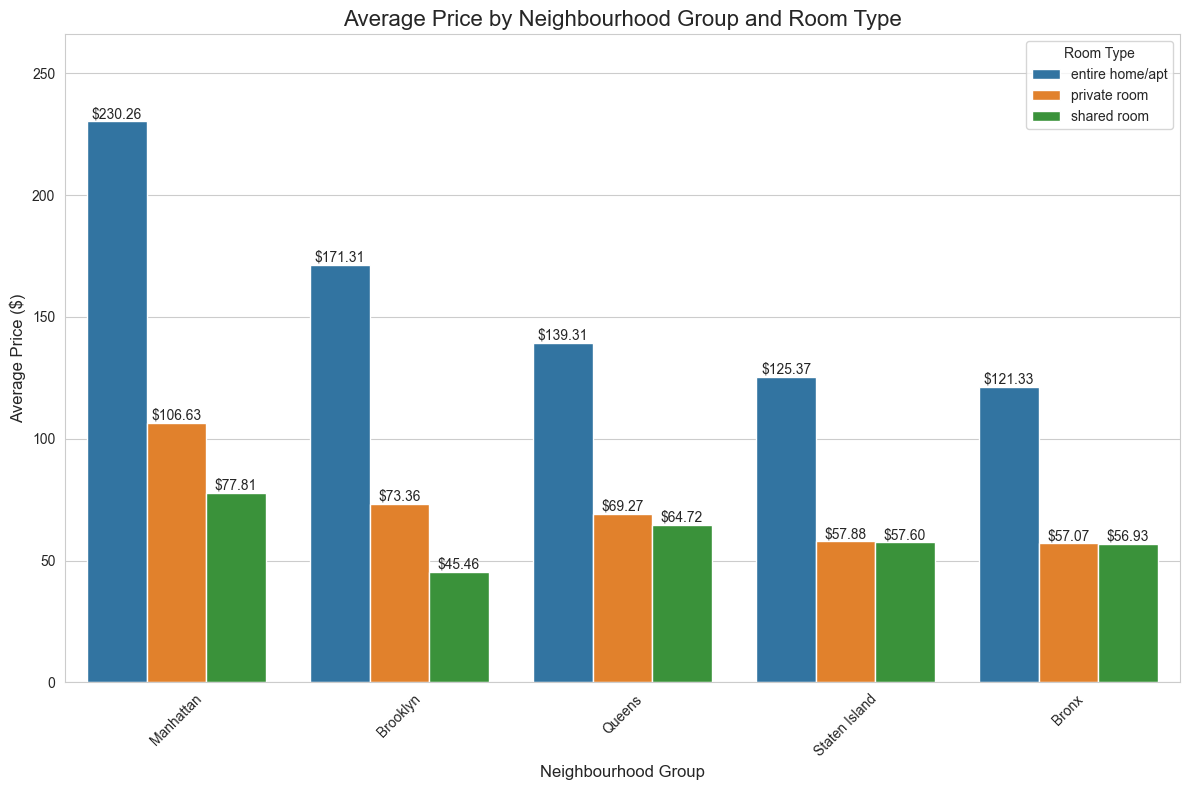

Total number of host listings in each neighbourhood group, sorted from highest to lowest:

+-------------------+--------------+
|neighbourhood_group|total_listings|
+-------------------+--------------+
|          Manhattan|         16564|
|           Brooklyn|         16395|
|             Queens|          4538|
|              Bronx|           864|
|      Staten Island|           311|
+-------------------+--------------+

Display the Pandas DataFrame:

  neighbourhood_group  total_listings
0           Manhattan           16564
1            Brooklyn           16395
2              Queens            4538
3               Bronx             864
4       Staten Island             311


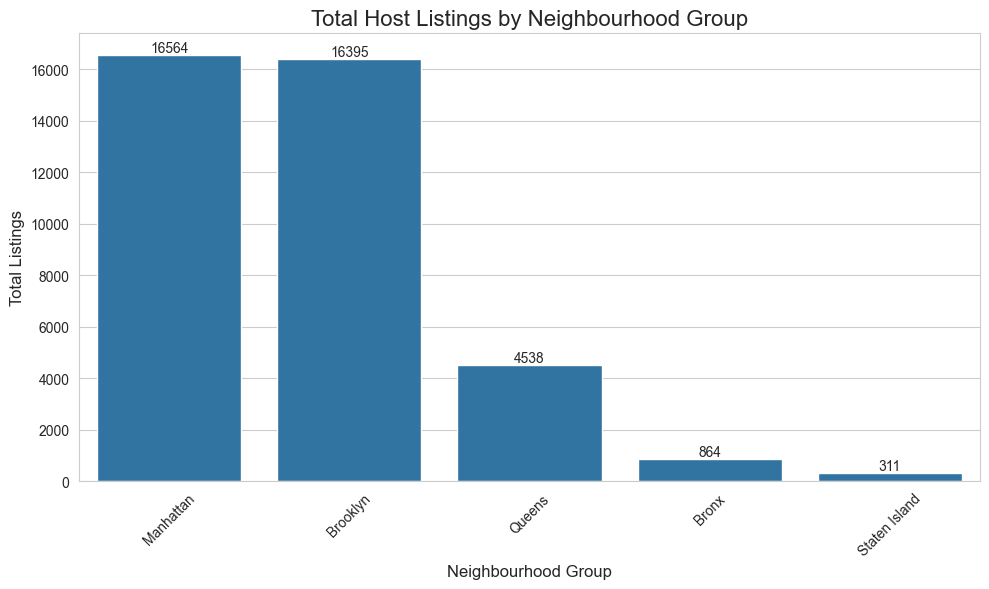

Top 10 hosts with the highest number of listings:

+------------+-------------+
|   host_name|listing_count|
+------------+-------------+
|     Michael|          335|
|       David|          308|
|        John|          250|
|        Alex|          229|
|Sonder (NYC)|          207|
|       Sarah|          179|
|       Maria|          173|
|     Jessica|          170|
|      Daniel|          170|
|        Anna|          159|
+------------+-------------+

Display the Pandas DataFrame:

      host_name  listing_count
0       Michael            335
1         David            308
2          John            250
3          Alex            229
4  Sonder (NYC)            207
5         Sarah            179
6         Maria            173
7       Jessica            170
8        Daniel            170
9          Anna            159


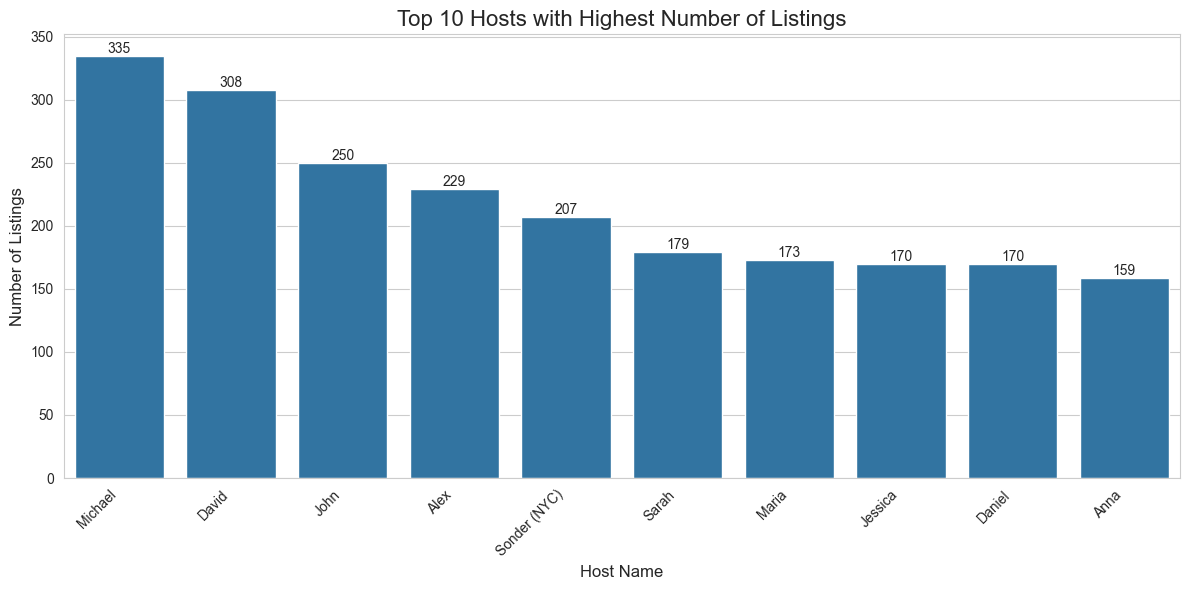

Top 20 hosts with the highest average number of reviews by room type:

+-------------------+---------------+-----------+
|host_name          |room_type      |avg_reviews|
+-------------------+---------------+-----------+
|Dona               |private room   |602.5      |
|Asa                |entire home/apt|488.0      |
|Lloyd              |shared room    |454.0      |
|Dennis & Naoko     |entire home/apt|441.0      |
|Miss Dy            |entire home/apt|434.0      |
|Shunichi           |private room   |430.0      |
|Gladys & Bob       |entire home/apt|414.0      |
|Janet-David        |entire home/apt|404.0      |
|Sne                |private room   |396.0      |
|Malini             |private room   |392.0      |
|Jj                 |private room   |386.6      |
|Amia               |entire home/apt|385.0      |
|J. E               |entire home/apt|378.0      |
|Waldemar           |private room   |353.0      |
|Kishorie           |entire home/apt|352.0      |
|Nalicia            |private 

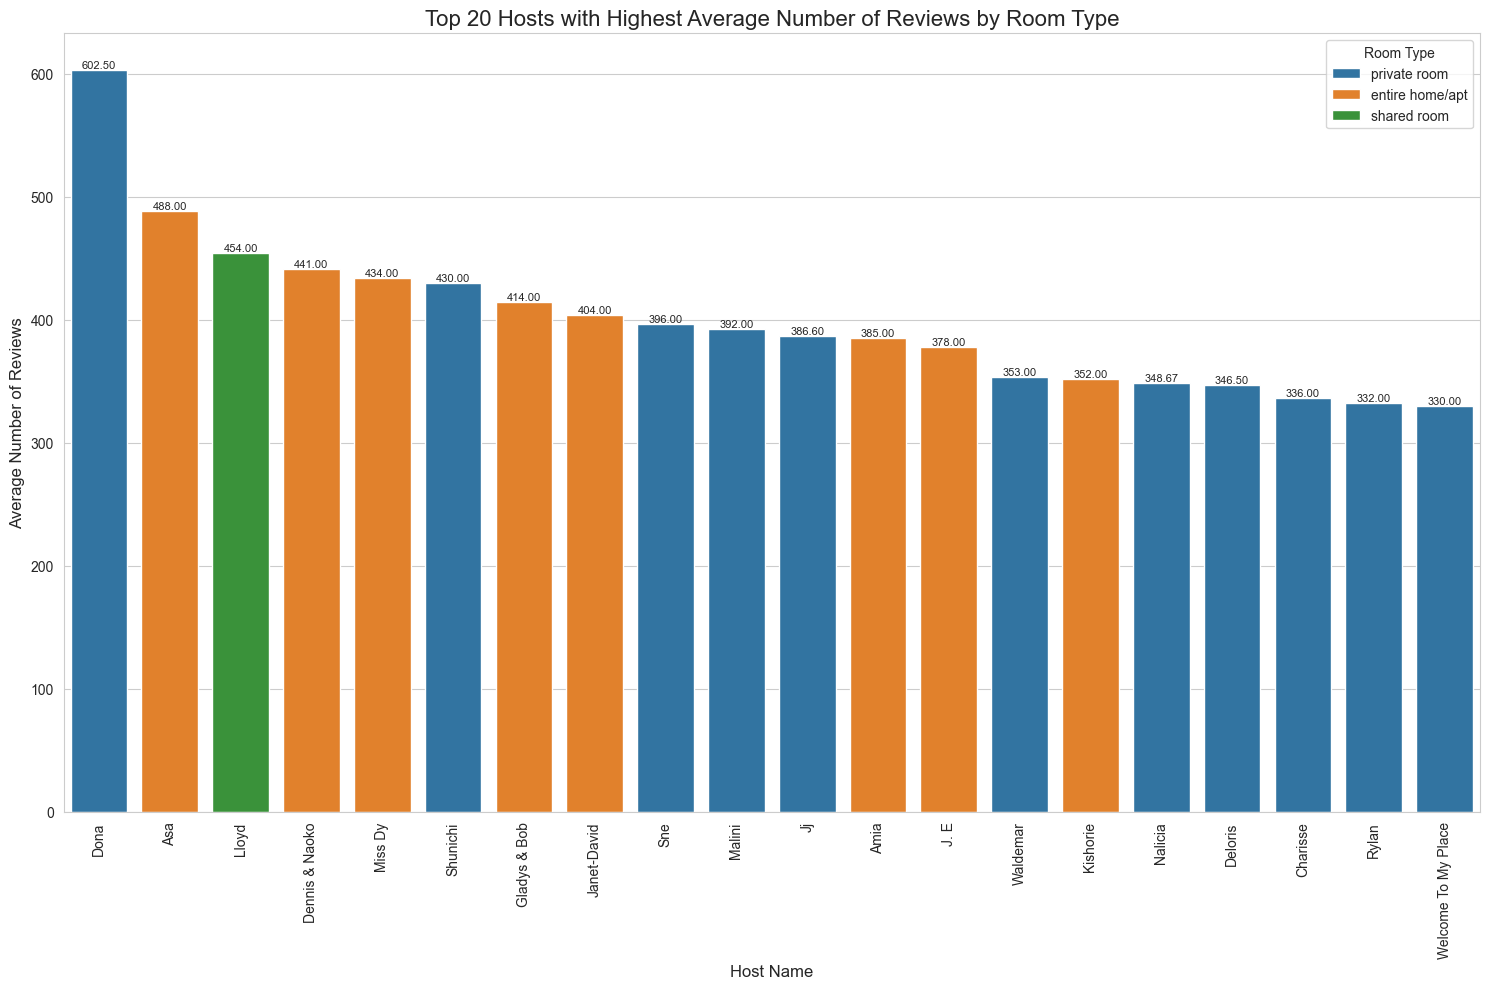

In [62]:
""" Question 2(e) (16 marks) """
print("\nQuestion 2(e) (16 marks)\n")

print("Show the combined DataFrame:\n")

combined_PySpark_DF.show(10)


""" Calculate the average price for each combination of neighbourhood group and room type. """
sorted_average_price_by_neighbourhood_group_and_room_type_PySpark_DF = combined_PySpark_DF\
    .groupBy("neighbourhood_group", "room_type") \
    .agg(
        round(avg("price"), 2)\
            .alias("average_price")
    ) \
    .orderBy(
        col("average_price").desc()
    )

# Show the results
print("Average price for each neighbourhood_group and room type, sorted from highest to lowest:\n")

sorted_average_price_by_neighbourhood_group_and_room_type_PySpark_DF.show()


""" Convert to Pandas DataFrame for easier plotting """
sorted_average_price_by_neighbourhood_group_and_room_type_Pandas_DF = sorted_average_price_by_neighbourhood_group_and_room_type_PySpark_DF.toPandas()

# Display the Pandas DataFrame
print(f"Display the Pandas DataFrame:\n\n{sorted_average_price_by_neighbourhood_group_and_room_type_Pandas_DF}")


# Set up the plot
plt.figure(figsize=(12, 8))

""" Create a bar plot using the seaborn library. """
ax = sns.barplot(x='neighbourhood_group', y='average_price', hue='room_type', data=sorted_average_price_by_neighbourhood_group_and_room_type_Pandas_DF)


# Customize the plot

""" Customize the plot with a title. """
plt.title('Average Price by Neighbourhood Group and Room Type', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Neighbourhood Group', fontsize=12)

plt.ylabel('Average Price ($)', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=45)

""" Customize the plot with a legend. """
plt.legend(title='Room Type')

""" Add value labels on top of each bar. """
for container in ax.containers:
    ax.bar_label(container, fmt='${:.2f}', label_type='edge')

""" Adjusts the y-axis limit. """
plt.ylim(0, plt.ylim()[1] * 1.1)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()




""" Count the number of listings for each neighbourhood group. """
host_listings_by_neighbourhood_group_PySpark_DF = combined_PySpark_DF\
    .groupBy("neighbourhood_group") \
    .agg(
        count("id")
        .alias("total_listings")
    ) \
    .orderBy(
        col("total_listings")\
        .desc()
    )

# Show the results
print("Total number of host listings in each neighbourhood group, sorted from highest to lowest:\n")

host_listings_by_neighbourhood_group_PySpark_DF.show()


""" Convert to Pandas DataFrame for easier manipulation if needed """
host_listings_by_neighbourhood_group_Pandas_DF = host_listings_by_neighbourhood_group_PySpark_DF.toPandas()

# Display the Pandas DataFrame
print(f"Display the Pandas DataFrame:\n\n{host_listings_by_neighbourhood_group_Pandas_DF}")


# Set up the plot
plt.figure(figsize=(10, 6))

# Create the bar plot
sns.barplot(x='neighbourhood_group', y='total_listings', data=host_listings_by_neighbourhood_group_Pandas_DF)


# Customize the plot

""" Customize the plot with a title. """
plt.title('Total Host Listings by Neighbourhood Group', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Neighbourhood Group', fontsize=12)

plt.ylabel('Total Listings', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=45)

""" Add value labels on top of each bar. """
for i, v in enumerate(host_listings_by_neighbourhood_group_Pandas_DF['total_listings']):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()




""" Group by host_name and count the number of listings. """
host_names_by_listings_count_PySpark_DF = combined_PySpark_DF\
    .groupBy("host_name") \
    .agg(
        count("id")\
        .alias("listing_count")
    ) \
    .orderBy(
        col("listing_count")\
        .desc()
    ) \
    .limit(10)

# Show the results
print("Top 10 hosts with the highest number of listings:\n")

host_names_by_listings_count_PySpark_DF.show()


""" Convert to Pandas DataFrame for easier manipulation if needed """
host_names_by_listings_count_Pandas_DF = host_names_by_listings_count_PySpark_DF.toPandas()

# Display the Pandas DataFrame
print(f"Display the Pandas DataFrame:\n\n{host_names_by_listings_count_Pandas_DF}")


# Set up the plot
plt.figure(figsize=(12, 6))

# Create the bar plot
sns.barplot(x='host_name', y='listing_count', data=host_names_by_listings_count_Pandas_DF)


# Customize the plot

""" Customize the plot with a title. """
plt.title('Top 10 Hosts with Highest Number of Listings', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Host Name', fontsize=12)

plt.ylabel('Number of Listings', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=45, ha='right')

""" Add value labels on top of each bar. """
for i, v in enumerate(host_names_by_listings_count_Pandas_DF['listing_count']):
    plt.text(i, v, str(v), ha='center', va='bottom')

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()




""" Group by host_name and room_type, calculate average number of reviews. """
host_names_and_room_type_by_average_reviews_PySpark_DF = combined_PySpark_DF\
    .groupBy("host_name", "room_type") \
    .agg(
        round(avg("number_of_reviews"), 2)\
        .alias("avg_reviews")
    ) \
    .orderBy(
        col("avg_reviews")\
        .desc()
    ) \
    .limit(20)

# Show the results
print("Top 20 hosts with the highest average number of reviews by room type:\n")

""" Use truncate=False to show the full content of each column. """
host_names_and_room_type_by_average_reviews_PySpark_DF.show(20, truncate=False)


""" Convert to Pandas DataFrame for easier manipulation if needed """
host_names_and_room_type_by_average_reviews_Pandas_DF = host_names_and_room_type_by_average_reviews_PySpark_DF.toPandas()

# Display the Pandas DataFrame
print(f"Display the Pandas DataFrame:\n\n{host_names_and_room_type_by_average_reviews_Pandas_DF}")


# Set up the plot
plt.figure(figsize=(15, 10))

""" Create a bar plot using the seaborn library. """
sns.barplot(x='host_name', y='avg_reviews', hue='room_type', data=host_names_and_room_type_by_average_reviews_Pandas_DF)


# Customize the plot

""" Customize the plot with a title. """
plt.title('Top 20 Hosts with Highest Average Number of Reviews by Room Type', fontsize=16)

""" Customize the plot with labels. """
plt.xlabel('Host Name', fontsize=12)

plt.ylabel('Average Number of Reviews', fontsize=12)

""" Customize the plot with rotated x-axis labels for better readability. """
plt.xticks(rotation=90)

""" Customize the plot with a legend. """
plt.legend(title='Room Type')

""" Add value labels on top of each bar.

The value labels on top of each bar provide the 

exact average number of reviews for each host and room type combination.c"""
for i, v in enumerate(host_names_and_room_type_by_average_reviews_Pandas_DF['avg_reviews']):
    plt.text(i, v, f'{v:.2f}', ha='center', va='bottom', fontsize=8)

# Adjust the layout
plt.tight_layout()

# Display the plot
plt.show()



**Average Price by Neighbourhood Group and Room Type Side-By-Side Bar Chart Insights:**

1st Insight:

The 1st insight is the room type entire home/apartment consistently had the highest average price across all the neighbourhood groups which means that the room type entire home/apartment was the most expensive room type which suggest a higher premiums for the room type entire home/apartment.

2nd Insight:

The 2nd insight is the room type shared rooms consistently had the lowest average price across all the neighbourhood groups which means that the room type shared rooms was the most affordable room type.

**Total Host Listings by Neighbourhood Group Bar Chart Insights:**

1st Insight:

The 1st insight is the neighbourhood groups Manhatttan and Brooklyn have the most number of Host Listings with 16564 and 16395 listings compared to the other neighbourhood groups which means that Manhattan and Brooklyn have the largest Airbnb Market share.

2nd Insight:

The 2nd insight is the distribution of Airbnb Host Listings data is very unenven across the various neighbourhood groups because Manhattan and Brookyln account for majority of the Airbnb Host Listings while the other neighbourhood groups such as Queens, Bronx and Staten Island only account for a small share of the Airbnb Host Listings.

**Top 10 Hosts with Highest Number of Listings Bar Chart Insights:**

1st Insight:

The 1st insight is the Michael has the highest number of Airbnb Listings at 335 which means that he is the top host and Michael is followed by David who has the 2nd highest number of Airbnb Listings at 308 which means that he is the 2nd most popular host while Anna has the least number of Airbnb Listings at 159 making her the least popular host.

2nd Insight:

The 2nd insight is the 2 hosts Jessica and Daniel both have the same number of Airbnb Listings at 170 and the data distribution of Airbnb Hosts Listings gradually increases from Anna to Michael.


**Top 20 Hosts with Highest Average Number of Reviews by Room Type Bar Chart Insights:**

1st Insight:

The 1st insight is the Host Dora has the highest average number of reviews at 602.50 for the Room Type private room while the Host Welcome To My Place has the least average number of reviews at 330.00 for the Room Type private room.

2nd Insight:

The 2nd insight is that 19 out of 20 of the top Hosts with the Highest Average Number of Reviews which means a mass majority are reviewed by the Room Type's private room and home/aprtments with only 1 host Lloyed is in the top 20 reviewed by the Room Type shared room.

In [63]:
spark.stop()